# Logistic Regression Exoplanet Vetter

## Imports and directories

In [13]:
import sys, os
import numpy as np
import pandas as pd # to read CSV
from sklearn import model_selection, preprocessing # for multivariable linear regression
import sklearn.linear_model as lm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import sklearn.metrics as skm
import h5py
import gc
import time
for obj in gc.get_objects():   # Browse through ALL objects
    if isinstance(obj, h5py.File):   # Just HDF5 files
        try:
            obj.close()
        except:
            pass # Was already closed

sectors = ["sector-{}".format(i) for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,17,18,19,20,21]]

# Manually point to TICS folder which contains labels.tsv
TICS_dropbox = "/Users/hblim/Dropbox (MIT)/qlp-data/TICS"

# Manually point to TICS folder which has preprocessed lightcurves
TICS_drive   = "/Volumes/halston_lim/School_Documents/SP_2019-2020/6.862/TICS/"

## Import Data and Count existing files

In [16]:
# get all files that have lightcurves
filelist = []
for i,sector in enumerate(sectors):
    filelist += os.listdir(os.path.join(TICS_drive,sector,"preprocessed"))
filelist = list(set(filelist))
print(len(filelist),"lightcurve files")

134628 lightcurve files


In [17]:
labels_tsv = np.genfromtxt(os.path.join(TICS_dropbox,"labels.tsv"),skip_header = 3,usecols=(0),dtype='i8')

# get files from 
filelist = open(os.path.join(TICS_drive,"filelist.txt"),'r').readlines()
filelist = set([i.strip() for i in filelist])

labels_str = set([str(labels_tsv[i]) + '.h5' for i in range(len(labels_tsv))])
print("total files: ", len(filelist))
print("total planets: ", len(filelist.intersection(labels_str)))
print("total missing: ", len(labels_str - filelist.intersection(labels_str)))

missing = list(labels_str - filelist.intersection(labels_str))
fout = open(os.path.join(TICS_drive,"missing.txt"),'w')
for m in missing:
    fout.write(m + '\n')
fout.close()

total files:  134628
total planets:  800
total missing:  893


In [18]:
# Global folder paths
datapath  = "/Volumes/halston_lim/School_Documents/SP_2019-2020/6.862/TICS/"

# Manually include which sectors names to scan
sectors = ["sector-{}".format(i) for i in \
           [1,2,3,4,5,6,7,8,9,10,11,12,13,14,17,18,19,20,21]]

data = np.zeros((0,20))
for i in range(len(sectors)):
    datatemp = np.load(os.path.join(datapath,sectors[i],'lcFeatures.npy'))
    data = np.append(data,datatemp,axis = 0)

In [19]:
n_planet = np.sum(data[:,-1] == 1)
n_nonplanet = np.sum(data[:,-1] == 0)
n_planet,n_nonplanet,n_planet / n_nonplanet

(782, 131481, 0.005947627413846868)

## Use all data columns

In [55]:
X = data[:,0:-1]
y = data[:,-1] * 2 - 1

kfold_score = [] # RMSE per case
kfold_predict = [] # predict class

n_cases = (X.shape)[0]
nfolds = 5
nthreshs = 20
kfold_predict = []
kfold_classifies = np.zeros((nfolds,5),dtype='i8')
kfold_probabilities = np.zeros((nfolds,5,nthreshs),dtype='i8')

precision_recall = []

kfold = model_selection.StratifiedKFold(n_splits = nfolds,shuffle=True)
i = 0
t0 = time.time()
for train_index, test_index in kfold.split(X,y):

    t0 = time.time()
    
    # split into test, training
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # scale training data
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train_sc = scaler.transform(X_train)
    
    # regress
    reg = lm.LogisticRegression( \
                                penalty='l2',
                                fit_intercept=True,
                                C = 1.0,
                                random_state=420,
                                solver='sag',
                                tol = 1e-4,
                                class_weight = 'balanced',
                                max_iter = 2500,
                                multi_class='ovr',
                                warm_start=True
                               )
    reg.fit(X_train_sc,y_train)

    # scale test data and predict
    X_test_sc = scaler.transform(X_test)
    prediction = reg.predict(X_test_sc)
    probabilities = reg.predict_proba(X_test_sc)
    kfold_predict.append(prediction)
    
    precision_recall.append(skm.precision_recall_curve(np.array(y_test),probabilities[:,1],pos_label=1))

    # evaluate fold
    yt = np.array(y_test)
    right = (yt - prediction == 0)
    planet = (yt == 1)
    
    n_total = len(yt)
    n_true = np.sum(right)
    n_true_planet = np.sum(np.logical_and(right,planet))
    n_falsepos = np.sum(np.logical_and(~right,~planet))
    n_falseneg = np.sum(np.logical_and(~right,planet))

    kfold_classifies[i][0] = n_total
    kfold_classifies[i][1] = np.sum(planet)
    kfold_classifies[i][2] = n_true_planet
    kfold_classifies[i][3] = n_falsepos
    kfold_classifies[i][4] = n_falseneg
    
    
    print("Fold #{}: {:.4f}".format(i,time.time() -t0))
    i += 1

Fold #0: 41.6953
Fold #1: 54.2924
Fold #2: 45.2977
Fold #3: 57.0006
Fold #4: 49.1922


(1000,)
(1000,)
(1000,)
(1000,)
(1000,)


Text(0.5, 0, 'Recall')

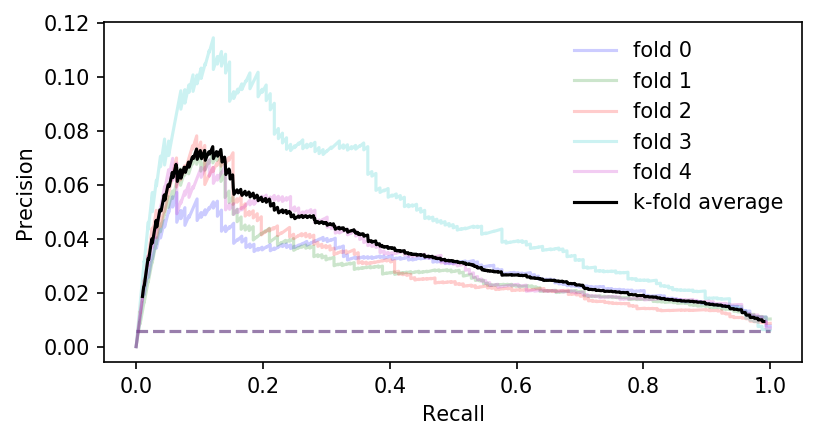

In [56]:
plt.figure(figsize = (6,3),dpi = 150)

xp = np.linspace(0.01,.99,1000)
yp = np.zeros((nfolds,len(xp)))

colors = ['b','g','r','c','m']

for i in range(nfolds):
    noskill = kfold_classifies[i,1] / kfold_classifies[i,0] 
    plt.plot(precision_recall[i][1][:-1],precision_recall[i][0][:-1],color=colors[i],alpha=0.2,label="fold {}".format(i))
    plt.plot([0,1],[noskill,noskill],color=colors[i],linestyle='--',alpha=0.2)
    yp[i] = np.interp(xp,precision_recall[i][1][-1:0:-1],precision_recall[i][0][-1:0:-1])
    print(yp[i].shape)

# average
plt.plot(xp,np.mean(yp,axis=0),'k-',label='k-fold average')

plt.legend(frameon=False)
plt.ylabel('Precision')
plt.xlabel('Recall')